In [11]:
import importlib
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
import lib.utils_RSA as rsa
from lib.algos import *
from scipy.spatial import procrustes as scipro

importlib.reload(rsa)

<module 'lib.utils_RSA' from '/home/alban/projects/SAYCam_Vs_EGO4D/lib/utils_RSA.py'>

In [12]:
dataset = 'imagenetVal'
models  = ['ego', 'saycam', 'imagenet', 'supervised', 'random', 'resnet']
path2activations = f'/home/alban/Documents/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

activations[model].shape


(50000, 2048)

In [18]:
### check if images were shown in the same order
assert imagelists['ego'] == imagelists['saycam']
imagelist = imagelists['ego'] # since they are the same, only consider one list

#### check if each category has the same number of images and list all categories in listcats
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[-2]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count # in val, 50 images per cate
nb_per_cat

50

In [21]:
### reshape activations according to include categories
cat_activations = activations.copy()

for model in models:
    norms = np.linalg.norm(activations[model], axis=1, keepdims=True)
    activations[model] = activations[model]/norms # normalization
    shape = activations[model].shape
    cat_activations[model] = cat_activations[model].reshape(-1, nb_per_cat, shape[-1])

In [8]:
compactness2 = {}
compact_categories2 = {}
for model in models:
    nb_cats = len(cat_activations[model])
    mean_normalized_cat_var = list()

    print(model)
    for c in range(nb_cats): # loop over categories
        # Fix: Create mask for current category c, not always category 0
        mask = np.arange(0, nb_cats) == c

        # Current category centroid
        centroid = np.mean(cat_activations[model][c], axis=0)

        # Intra-category variance (variance within current category)
        intra_var = np.mean((cat_activations[model][c] - centroid)**2, axis=0)

        # Inter-category variance (variance of other categories relative to current centroid)
        other_categories = [cat_activations[model][i] for i in range(nb_cats) if i != c]
        other_activations = np.concatenate(other_categories, axis=0)
        inter_var = np.mean((other_activations - centroid)**2, axis=0)

        # Normalize intra-category variance by inter-category variance
        normalized_cat_var = intra_var / inter_var
        mean_normalized_cat_var.append(normalized_cat_var.mean())

    mean_normalized_cat_var = np.array(mean_normalized_cat_var)
    compactness2[model] = np.sort(mean_normalized_cat_var)
    compact_categories2[model] = np.array(listcat)[np.argsort(mean_normalized_cat_var)]

ego


KeyboardInterrupt: 

In [23]:
def compute_compactness_memory_efficient(cat_activations, models, listcat):
    """
    Memory-efficient version that processes one model at a time and uses generators.
    Good for very large datasets.
    """
    compactness2 = {}
    compact_categories2 = {}

    for model in models:
        print(model)
        n_cats = len(cat_activations[model])

        # Pre-compute centroids
        centroids = np.array([np.mean(cat_act, axis=0) for cat_act in cat_activations[model]])

        # Compute metrics using generator expressions to save memory
        intra_vars = np.array([
            np.mean((cat_activations[model][i] - centroids[i])**2)
            for i in range(n_cats)
        ])

        inter_vars = np.array([
            np.mean([
                np.mean((cat_activations[model][j] - centroids[i])**2)
                for j in range(n_cats) if j != i
            ])
            for i in range(n_cats)
        ])

        # Compute normalized variances
        normalized_vars = intra_vars / inter_vars

        # Sort and store results
        sort_indices = np.argsort(normalized_vars)
        compactness2[model] = normalized_vars[sort_indices]
        compact_categories2[model] = np.array(listcat)[sort_indices]

    return compactness2, compact_categories2

compactness3, compact_categories3 = compute_compactness_memory_efficient(cat_activations, models, listcat)

ego
saycam
imagenet
supervised
random
resnet


In [22]:
for model in models:
    print(cat_activations[model].shape)

(1000, 50, 768)
(1000, 50, 768)
(1000, 50, 768)
(1000, 50, 768)
(1000, 50, 768)
(1000, 50, 2048)


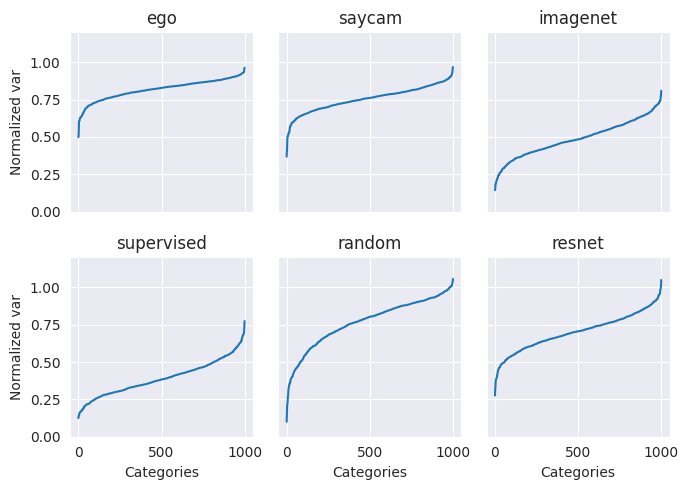

ego
['n02701002' 'n04487081' 'n06359193' 'n03769881' 'n04335435' 'n12057211'
 'n13044778' 'n03841143' 'n03290653' 'n03777568' 'n03977966' 'n03590841'
 'n09288635' 'n03272562' 'n02111129' 'n04065272' 'n03770679' 'n04243546'
 'n03916031' 'n01843065']
saycam
['n02701002' 'n06359193' 'n04487081' 'n03769881' 'n02111129' 'n03977966'
 'n04335435' 'n13044778' 'n03272562' 'n03345487' 'n03290653' 'n03599486'
 'n04065272' 'n03777568' 'n04146614' 'n03770679' 'n03417042' 'n13037406'
 'n04525305' 'n03841143']
imagenet
['n12057211' 'n03841143' 'n01773157' 'n02279972' 'n01843065' 'n04487081'
 'n13037406' 'n01872401' 'n02701002' 'n13044778' 'n11939491' 'n02606052'
 'n02391049' 'n02951358' 'n02276258' 'n12985857' 'n02128385' 'n01817953'
 'n02643566' 'n02281406']
supervised
['n01872401' 'n03924679' 'n01773157' 'n03841143' 'n02116738' 'n03544143'
 'n02013706' 'n04487081' 'n02917067' 'n01518878' 'n02128385' 'n13044778'
 'n02391049' 'n01774750' 'n03218198' 'n03956157' 'n02130308' 'n04505470'
 'n12057211' 'n

In [25]:
import math
def plot_stats(SIMs, submodels, labels = ['label1', 'label2']):
    '''plot the compactness as a function of sorted image category.
    Plot is a subplot of adaptative size, depending on the length of the list submodel given.
    '''
    nb_subs = len(submodels) # Number of subs
    sqrt = np.sqrt(nb_subs)
    cols = math.ceil(sqrt)
    rows = math.ceil(nb_subs // sqrt)
    while (cols*rows)<(nb_subs):
        rows =rows + 1 ## compute the number of columns and rows
    fig, subs = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(cols*2+1, rows*2+1)) # adaptative size
    count = 0
    minval = 1
    maxval = 0
    for i, model in enumerate(submodels):
        minval = min(minval, np.amin(SIMs[model]))
        maxval = max(maxval, np.amax(SIMs[model]))
        if rows ==1:
            subs[count%cols].plot(SIMs[model])
            subs[count%cols].set_title(f'{model}')
        else:
            subs[count//cols, count%cols].plot(SIMs[model])
            subs[count//cols, count%cols].set_title(f'{model}')
            count+=1
    maxval = min(maxval, 1.1)
    plt.ylim(np.round(minval,1)-0.1, np.round(maxval,1)+0.1)
    if rows == 1:
        subs[0].set_ylabel(labels[1])
        for sub in subs:
            sub.set_xlabel(labels[0])
    else:
        for sub in subs[-1]:
            sub.set_xlabel(labels[0])
        for sub in subs[:,0]:
            sub.set_ylabel(labels[1])

    fig.tight_layout()
    plt.show()
    plt.close()

plot_stats(compactness3,models,  ['Categories', 'Normalized var'])
for model in models:
    print(f'{model}')
    print(compact_categories3[model][:20])
for model in models:
    print(compact_categories3[model][-20:])

In [28]:
def check_list_similarity(list1, list2):
    '''Checks if two lists contain the same elements, regardless of order,
    and calculates the proportion of common elements.'''
    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1 & set2  # Intersection of sets
    proportion = (len(common_elements) / max(len(set1), len(set2))) * 100 if max(len(set1), len(set2)) > 0 else 0
    return proportion

print('\nSimilarities saycam and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories3['saycam'][:50],compact_categories3[model][:50]))

print('\nSimilarities ego and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories3['ego'][:50],compact_categories3[model][:50]))

print('\nSimilarities imagenet and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories3['imagenet'][:50],compact_categories3[model][:50]))

print('\nSimilarities supervised and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories3['supervised'][:50],compact_categories3[model][:50]))

print('\nSimilarities resnet and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories3['resnet'][:50],compact_categories3[model][:50]))


Similarities saycam and the others
78.0
100.0
40.0
22.0
14.000000000000002
74.0

Similarities ego and the others
100.0
78.0
42.0
20.0
20.0
68.0

Similarities imagenet and the others
42.0
40.0
100.0
42.0
18.0
26.0

Similarities supervised and the others
20.0
22.0
42.0
100.0
12.0
14.000000000000002

Similarities resnet and the others
68.0
74.0
26.0
14.000000000000002
10.0
100.0


In [29]:
### Compute 500 random sequence for significance
# initialize sequences
nb_trials = 500
idx_vec = np.array(range(len(listcat)))
mat_vec = np.zeros((nb_trials, len(idx_vec)))
for i in range(nb_trials):
    np.random.shuffle(idx_vec)
    mat_vec[i] = idx_vec

#Compute all possible similarity pairs
list_sim = []
for i in range(len(mat_vec)-1):
    for j in range(i+1,len(mat_vec)):
        list_sim.append(check_list_similarity(list(mat_vec[i][:50]), list(mat_vec[j][:50])))

# Compute 95 percentile
confinter = np.percentile(list_sim, 95)
print(f'The 95% confidence interval is:{confinter}')

The 95% confidence interval is:10.0


In [32]:
def max_compactness_difference(compact_categories, compactness, models = ['saycam', 'ego'], nb_max_compactness = 10):
    '''
    Function that sorts categories following the maximum difference in compactness given 2 models
    '''
    nb_categories = cat_activations[models[0]].shape[0]
    ori_cat = np.arange(0,nb_categories)
    comp_cat = np.zeros(nb_categories)
    for c, cat in enumerate(compact_categories[models[0]]):
        comp_cat[c] = compact_categories[models[1]].tolist().index(cat) # rank for model2 the categories sorted for model1

    #diff = np.absolute(comp_cat - ori_cat) # distance in terms of rank
    diff = np.absolute(compactness[models[0]][comp_cat.astype(int)] - compactness[models[0]][ori_cat.astype(int)]) # distance in terms of compactness
    sortedmaxdiffcats = np.array(listcat)[np.argsort(-diff)]
    maxdiffs = np.sort(diff)[::-1]

    labels = np.argsort(-diff)
    max_compactness_cats = sortedmaxdiffcats[:nb_max_compactness]
    print(f'The {nb_max_compactness} categories leading to the max differences between {models[0]} and {models[1]} are {sortedmaxdiffcats[:nb_max_compactness]}')
    print(f'Category numbers are {labels[:nb_max_compactness]}')
    print(f'With differences in compactness of  {maxdiffs[:nb_max_compactness]}')

    return labels, sortedmaxdiffcats, maxdiffs

In [38]:
labels3, sortedmaxdiffcats3, maxdiffs3 = max_compactness_difference(compact_categories3, compactness3, models = ['saycam', 'imagenet'], nb_max_compactness = 10)

The 10 categories leading to the max differences between saycam and imagenet are ['n02088238' 'n04554684' 'n01664065' 'n01443537' 'n01518878' 'n02395406'
 'n01558993' 'n01833805' 'n02783161' 'n01491361']
Category numbers are [161 897  33   1   9 341  15  94 418   3]
With differences in compactness of  [0.2691312  0.25123674 0.22832862 0.22660038 0.20826298 0.19760913
 0.1948064  0.18643758 0.17610425 0.17021647]


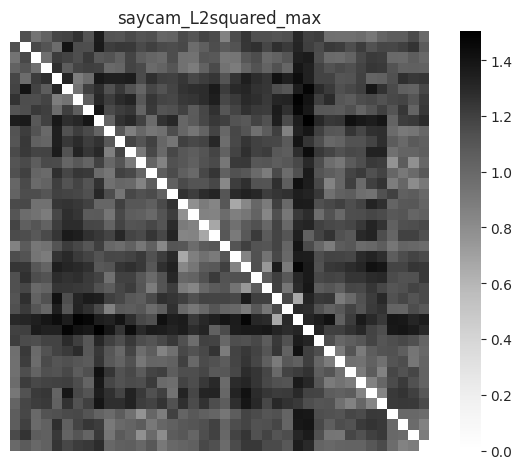

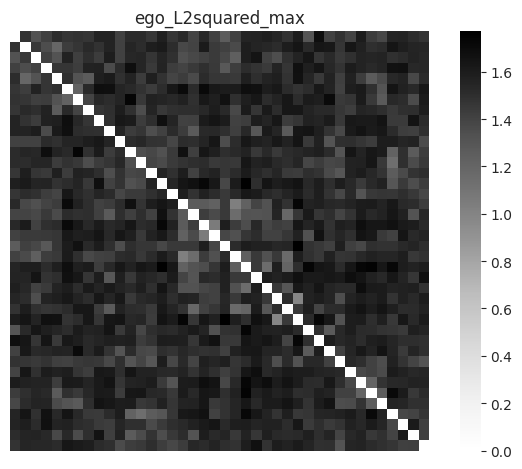

np.float64(0.6188307717585044)

In [39]:
    ### Let's check if the resulting RDMs really are very dissimilar! For the record, the average similarity should be around 0.6
## For now let's consider the 10 categories with max compactness difference, 4 random images in each category
nb_max_compactness = 10
imgspercat = 4 #
import random

cat_imgs = list() # list of nb_max_compactness*4 images
list_randidx = list(range(nb_per_cat))
list_selec_idx = list()
list
for icat in labels3[:nb_max_compactness]:# loop over first 10 categories with max compactness difference
    random.shuffle(list_randidx) # shuffle and take 4 first idx to sample 4 images randomly
    for cat_img in list_randidx[:imgspercat]:
        cat_imgs.append(imagelist[icat*nb_per_cat + cat_img])
        list_selec_idx.append(icat*nb_per_cat + cat_img)

metric = 'L2squared'
sim_metric = 'pearson'
### compute RSA
test_models = ['saycam', 'ego']
test_rdms = {}
for model in test_models:
    test_rdms[model] = rsa.compute_RDMs(activations[model][list_selec_idx], metric = metric, display = True, title = f'{model}_{metric}_max')

SIMs_saycam_ego = rsa.Compute_sim_RDMs(test_rdms['saycam'], test_rdms['ego'], center = False, metric = sim_metric)
SIMs_saycam_ego